# Capstone Project: King County House Price Predictions
# I. Data Wrangling 

__Overview__

The main dataset, House Sales in King County, USA, was from Kaggle (Link: https://www.kaggle.com/harlfoxem/housesalesprediction). This data contains house sale prices for King County included in the Seattle–Tacoma–Bellevue metropolitan area in Washington. The dataset has one year of records for houses sold between May 2014 and May 2015. It is not a recent data, but I will pretend it is. It consists of 19 house features, house id and sale price for 21,613 observations (i.e., sales). The house features include the number of bedrooms and bathrooms, square footages of home and lot, year built, zip code, latitude and longitude. Zip codes can give some pieces of information about the area where each house is located. They can help house price predictions since location of a house is one of the most important factors when buying houses. I found niche.com https://www.niche.com provides grades for public school, safety, cost of living, jobs, commute, etc for each entered zip code. Niche.com is likely to provide a more recent data, but I will ignore this concern since I am pretending my house data is recent. I will collect those grades for each zip code using web scraping and make a structured dataset. After cleaning both datasets, I will merge the collected zip code dataset into the original dataset. In other words, additional columns derived from zip codes will be added to the original house price dataset. 


1. <a href='#Section1'>House Data</a>
2. <a href='#Section2'>Zip code Data from Niche.com</a>
3. <a href='#Section3'>Merge zip code data into house data</a>

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import requests
from bs4 import BeautifulSoup 

<a id= 'Section1'></a>

## 1. House Data

I will first wrangle the original house sales data 'kc_house_data.csv'

In [2]:
df_house = pd.read_csv('kc_house_data.csv')

In [3]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


__Brief summary of data__

- 21,613 observations 
- 21 columns with house id, house features and price 
- No missing values
- Float or integer types except for 1 object type (date)
- Some data types need to be changed (e.g., id, date, zipcode) 

__Column Descriptions__

These are the desctriptions from the kaggle webpage. I added some comments in _italics_ to clarify meanings.

- id: Notation for a house
- date: Date house was sold
- price: Price is prediction target
- bedrooms: Number of Bedrooms/House 
_(/House seems to mean 'per house')_
- bathrooms: Number of bathrooms/bedrooms 
_(/bedrooms also seems to mean 'per house'. If it literally means 'per bedroom', the values are too big)_
- sqft_living: Square footage of the home
- sqft_lot: square footage of the lot
- floors: Total floors (levels) in house
- waterfront: House which has a view to a waterfront
- view: Has been viewed
- condition: How good the condition is (Overall)
- grade: Overall grade given to the housing unit, based on King County grading system
- sqft_above: Square footage of house apart from basement
- sqft_basement: Square footage of the basement
- yr_built: Built Year
- yr_renovated: Year when house was renovated
- zipcode: Zip
- lat: Latitude coordinate
- long: Longitude coordinate
- sqft_living15: Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
- sqft_lot15: Lot size area in 2015(implies-- some renovations)

In [4]:
df_house.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


lat                 AxesSubplot(0.125,0.125;0.168478x0.755)
long             AxesSubplot(0.327174,0.125;0.168478x0.755)
sqft_living15    AxesSubplot(0.529348,0.125;0.168478x0.755)
sqft_lot15       AxesSubplot(0.731522,0.125;0.168478x0.755)
dtype: object

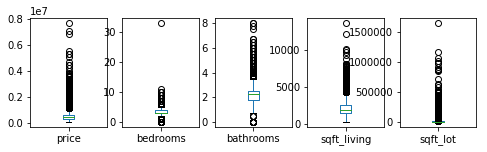

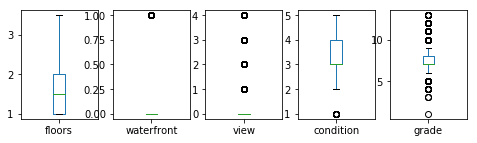

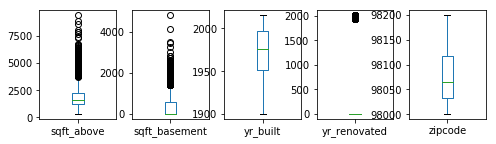

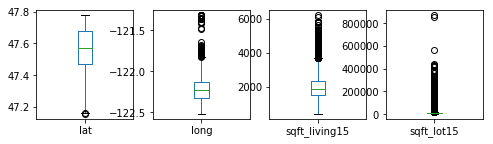

In [5]:
# Check boxplots for outliers
df_house.iloc[:,2:7].plot(kind='box', subplots=True, figsize = (8,2))
df_house.iloc[:,7:12].plot(kind='box', subplots=True, figsize = (8,2))
df_house.iloc[:,12:17].plot(kind='box', subplots=True, figsize = (8,2))
df_house.iloc[:,17:].plot(kind='box', subplots=True, figsize = (8,2))

I will check each column to find suspcious outliers and change data types if necessary, but some columns, from floor to the last column sqft_lot15 except for yr_renovated and zipcode, are not to be further checked individually since their values, minimum and maximum look completely normal here.

### id

In [6]:
df_house.id.nunique()

21436

In [7]:
21613-21436

177

The number of unique ids 21436 is less than the number of rows 21613 and this means there are redundant house ids. This could mean (1) there are duplicates of observations or (2) some houses were sold more than once.

In [8]:
# how many times each houses was sold
Counter(df_house.id).most_common(5)

[(795000620, 3),
 (6021501535, 2),
 (4139480200, 2),
 (7520000520, 2),
 (3969300030, 2)]

The same ids appear up to 3 times.

In [9]:
# Check house 795000620 which was sold 3 times
df_house[df_house.id==795000620]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17602,795000620,20140924T000000,115000.0,3,1.0,1080,6250,1.0,0,0,...,5,1080,0,1950,0,98168,47.5045,-122.33,1070,6250
17603,795000620,20141215T000000,124000.0,3,1.0,1080,6250,1.0,0,0,...,5,1080,0,1950,0,98168,47.5045,-122.33,1070,6250
17604,795000620,20150311T000000,157000.0,3,1.0,1080,6250,1.0,0,0,...,5,1080,0,1950,0,98168,47.5045,-122.33,1070,6250


In [10]:
# Check house 3969300030 which was sold twice
df_house[df_house.id==3969300030]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
345,3969300030,20140723T000000,165000.0,4,1.0,1000,7134,1.0,0,0,...,6,1000,0,1943,0,98178,47.4897,-122.24,1020,7138
346,3969300030,20141229T000000,239900.0,4,1.0,1000,7134,1.0,0,0,...,6,1000,0,1943,0,98178,47.4897,-122.24,1020,7138


In [11]:
# check house 6021501535 if its condition or yr_renovated were changed
df_house[df_house.id==6021501535][['id','date','price','condition','yr_renovated']]

,id,date,price,condition,yr_renovated
93,6021501535,20140725T000000,430000.0,3,0
94,6021501535,20141223T000000,700000.0,3,0


House prices and dates are all different, so it confirms that those rows with the same house id are not duplicates. They are just from different sales of the same house. I notice that later sale prices of a house are usually higher than its earlier prices. These price jumps in a short period could be from soaring house prices in the market, house renovations or house updates although the yr_renovated column does not support my second guess. Some houses are updated and their prices can go up, but these updates are not always recorded as a renovation. The id numbers are not likely to be useful numeric values, but the number of sales for each house during this period could be useful. Thus, I will make a new column __sales_order__ indicating whether it is the first, second or third sales during the period. Before making the column, I will change the type of id from integer to string

In [12]:
df_house.id = df_house.id.astype(str)

In [13]:
type(df_house.id[0])

str

In [15]:
# make sales_order
sales_count=defaultdict(int)
sales_order =[] # sale order for each hourse
for house_id in df_house.id:
    sales_count[house_id] +=1
    sales_order.append(sales_count[house_id])

In [16]:
Counter(sales_order)

Counter({1: 21436, 2: 176, 3: 1})

Looks correct!

In [17]:
# Add sales_order column
df_house['sales_order'] = sales_order

In [18]:
df_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,1
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,1
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,1
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,1


### date

In [19]:
df_house.date[:10]

0    20141013T000000
1    20141209T000000
2    20150225T000000
3    20141209T000000
4    20150218T000000
5    20140512T000000
6    20140627T000000
7    20150115T000000
8    20150415T000000
9    20150312T000000
Name: date, dtype: object

T000000 just means all day events, so they will be removed to leave dates only.

In [20]:
df_house.date[0][:-7]

'20141013'

In [21]:
date = pd.to_datetime(df_house.date.apply(lambda x: x[:-7]), format='%Y%m%d')
date[:10]

0   2014-10-13
1   2014-12-09
2   2015-02-25
3   2014-12-09
4   2015-02-18
5   2014-05-12
6   2014-06-27
7   2015-01-15
8   2015-04-15
9   2015-03-12
Name: date, dtype: datetime64[ns]

In [22]:
df_house.date = date
df_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,1
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,1
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,1


In [23]:
df_house.date.describe()

count                   21613
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

Looking good!

### price

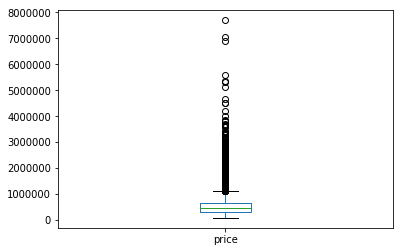

In [24]:
df_house.price.plot(kind='box') 

In [25]:
df_house.price.describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

It is pretty right-skwered and some houses are extremely expensive. I will check the most expensive and most cheapest houses if they are not suspicious outliers.

In [26]:
df_house[df_house.price == max(df_house.price)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
7252,6762700020,2014-10-13,7700000.0,6,8.0,12050,27600,2.5,0,3,...,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,1


This is a 7.7 million dollar house with 8 bathrooms and 6 bedrooms. This is not a suspicious outlier.

In [27]:
df_house[df_house.price == min(df_house.price)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
1149,3421079032,2015-02-17,75000.0,1,0.0,670,43377,1.0,0,0,...,670,0,1966,0,98022,47.2638,-121.906,1160,42882,1


This 75K dollar house has no bathroom, but it is plausible if this is not for living or if tenants have a shared bathroom outside.

### bedrooms

In [28]:
df_house.bedrooms.describe()

count    21613.000000
mean         3.370842
std          0.930062
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

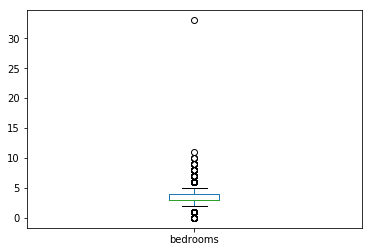

In [29]:
df_house.bedrooms.plot(kind='box') 

There is one suspicious singled out outlier. I will check other features of this house.

In [30]:
df_house[df_house.bedrooms == max(df_house.bedrooms)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
15870,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,...,1040,580,1947,0,98103,47.6878,-122.331,1330,4700,1


In [31]:
# check if this house was sold more than once
df_house[df_house.id == '2402100895']

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
15870,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,...,1040,580,1947,0,98103,47.6878,-122.331,1330,4700,1


This number of bedrooms 33 seems to be a typo and acutally 3 because all other house features including price indicate it is just an average house. This house was sold only once during this period, so there is no additional information. I will change 33 into 3.

In [32]:
print(df_house.bedrooms.iloc[15870])  
df_house.bedrooms = df_house.bedrooms.replace({33:3})
print(df_house.bedrooms.iloc[15870])

33
3


In [33]:
df_house[df_house.bedrooms == max(df_house.bedrooms)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
8757,1773100755,2014-08-21,520000.0,11,3.0,3000,4960,2.0,0,0,...,2400,600,1918,1999,98106,47.556,-122.363,1420,4960,1


I checked the house with the new maximum number of bedrooms. The house doe not look like a normal house since its price and square footages are too low comparing to the number of bedrooms. However, I cannot find any reason to remove or correct, so I will leave it there.

In [34]:
df_house[df_house.bedrooms==0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
875,6306400140,2014-06-12,1095000.0,0,0.00,3064,4764,3.5,0,2,...,3064,0,1990,0,98102,47.6362,-122.322,2360,4000,1
3119,3918400017,2015-02-05,380000.0,0,0.00,1470,979,3.0,0,2,...,1470,0,2006,0,98133,47.7145,-122.356,1470,1399,1
3467,1453602309,2014-08-05,288000.0,0,1.50,1430,1650,3.0,0,0,...,1430,0,1999,0,98125,47.7222,-122.290,1430,1650,1
4868,6896300380,2014-10-02,228000.0,0,1.00,390,5900,1.0,0,0,...,390,0,1953,0,98118,47.5260,-122.261,2170,6000,1
6994,2954400190,2014-06-24,1295650.0,0,0.00,4810,28008,2.0,0,0,...,4810,0,1990,0,98053,47.6642,-122.069,4740,35061,1
8477,2569500210,2014-11-17,339950.0,0,2.50,2290,8319,2.0,0,0,...,2290,0,1985,0,98042,47.3473,-122.151,2500,8751,1
8484,2310060040,2014-09-25,240000.0,0,2.50,1810,5669,2.0,0,0,...,1810,0,2003,0,98038,47.3493,-122.053,1810,5685,1
9773,3374500520,2015-04-29,355000.0,0,0.00,2460,8049,2.0,0,0,...,2460,0,1990,0,98031,47.4095,-122.168,2520,8050,1
9854,7849202190,2014-12-23,235000.0,0,0.00,1470,4800,2.0,0,0,...,1470,0,1996,0,98065,47.5265,-121.828,1060,7200,1
12653,7849202299,2015-02-18,320000.0,0,2.50,1490,7111,2.0,0,0,...,1490,0,1999,0,98065,47.5261,-121.826,1500,4675,1


I noticed the minimum number of bedrooms is zero and checked which houses have zero bedrooms. There are even some over million dollar houses. I investigated the house with the highest price among these observations (id=2954400190). I searched the house on Google Map using its longitude and latitude and found its address and checked its last sold price on Redfin.com is the same as above. It seems zero was entered for those observations with missing values on the bedroom feature. Since they are only 13 observations out of 21,613, I will remove those observations later.

### bathrooms

In [35]:
df_house.bathrooms.describe()

count    21613.000000
mean         2.114757
std          0.770163
min          0.000000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

In [36]:
df_house[df_house.bathrooms==0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
875,6306400140,2014-06-12,1095000.0,0,0.0,3064,4764,3.5,0,2,...,3064,0,1990,0,98102,47.6362,-122.322,2360,4000,1
1149,3421079032,2015-02-17,75000.0,1,0.0,670,43377,1.0,0,0,...,670,0,1966,0,98022,47.2638,-121.906,1160,42882,1
3119,3918400017,2015-02-05,380000.0,0,0.0,1470,979,3.0,0,2,...,1470,0,2006,0,98133,47.7145,-122.356,1470,1399,1
5832,5702500050,2014-11-04,280000.0,1,0.0,600,24501,1.0,0,0,...,600,0,1950,0,98045,47.5316,-121.749,990,22549,1
6994,2954400190,2014-06-24,1295650.0,0,0.0,4810,28008,2.0,0,0,...,4810,0,1990,0,98053,47.6642,-122.069,4740,35061,1
9773,3374500520,2015-04-29,355000.0,0,0.0,2460,8049,2.0,0,0,...,2460,0,1990,0,98031,47.4095,-122.168,2520,8050,1
9854,7849202190,2014-12-23,235000.0,0,0.0,1470,4800,2.0,0,0,...,1470,0,1996,0,98065,47.5265,-121.828,1060,7200,1
10481,203100435,2014-09-18,484000.0,1,0.0,690,23244,1.0,0,0,...,690,0,1948,0,98053,47.6429,-121.955,1690,19290,1
14423,9543000205,2015-04-13,139950.0,0,0.0,844,4269,1.0,0,0,...,844,0,1913,0,98001,47.2781,-122.250,1380,9600,1
19452,3980300371,2014-09-26,142000.0,0,0.0,290,20875,1.0,0,0,...,290,0,1963,0,98024,47.5308,-121.888,1620,22850,1


The above shows houses with no bathroom. They have zero or one bedrooms. For example, the first observation above has no bedroom and no bathroom, but it is over a million dollar and has 3.5 floors. I first thought "is it a parking garage building or something?", but after checking the bedroom feature I realized some of them are just missing values. Again, there are only 10 observations with no bathroom and 7 of them will be anyway removed when removing rows with no bedroom (i.e., only 3 rows left). Therefore, I will remove only 3 additional rows due to missing values on the number of bathrooms.

### sqft_living

In [37]:
df_house.sqft_living.describe()

count    21613.000000
mean      2079.899736
std        918.440897
min        290.000000
25%       1427.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

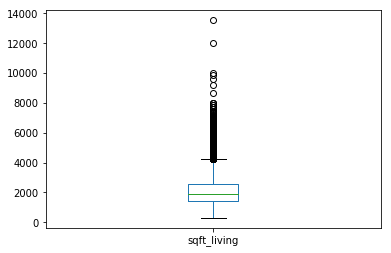

In [38]:
df_house.sqft_living.plot(kind='box')

In [39]:
df_house[df_house.sqft_living==max(df_house.sqft_living)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
12777,1225069038,2014-05-05,2280000.0,7,8.0,13540,307752,3.0,0,4,...,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,1


The maximum square footage house is extremely big (13,540 sqft), but the house looks like a normal huge house. 

In [40]:
df_house[df_house.sqft_living==min(df_house.sqft_living)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
19452,3980300371,2014-09-26,142000.0,0,0.0,290,20875,1.0,0,0,...,290,0,1963,0,98024,47.5308,-121.888,1620,22850,1


The minimum is too small (290 sqft) for a house, but this observation will be removed anyway when removing 0 bedroom and 0 bathroom houses. 

### sqft_lot

In [41]:
df_house.sqft_lot.describe()

count    2.161300e+04
mean     1.510697e+04
std      4.142051e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068800e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

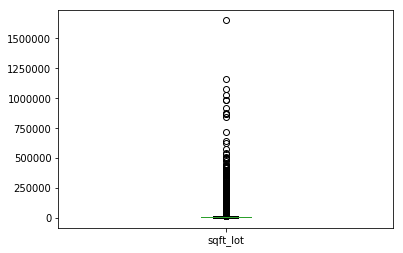

In [42]:
df_house.sqft_lot.plot(kind='box')

In [43]:
df_house[df_house.sqft_lot==max(df_house.sqft_lot)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
1719,1020069017,2015-03-27,700000.0,4,1.0,1300,1651359,1.0,0,3,...,1300,0,1920,0,98022,47.2313,-122.023,2560,425581,1


This house is an outlier with 1,651,359 sqft (38 acres) lot, but it is a possible number. It is a old (1920) small house with a huge lot by a cemetery according to Google Map.

### Remove rows with no bedroom and bathroom

Here I will remove the 16 rows with no bathroom or no bedroom since I found some of the zeros were entered for missing values and 13 observations are only 0.07% of all data. 

In [44]:
df_house = df_house[(df_house.bedrooms > 0) & (df_house.bathrooms > 0)]
df_house.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_order
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402029e+05,3.371811,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,1.008242
std,3.671337e+05,0.904096,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,0.090923
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,1.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,1.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,1.000000
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,3.000000


In [45]:
df_house.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            21603, 21604, 21605, 21606, 21607, 21608, 21609, 21610, 21611,
            21612],
           dtype='int64', length=21597)

I need to reset the index.

In [46]:
df_house = df_house.reset_index()
df_house.index

RangeIndex(start=0, stop=21597, step=1)

Looks great! Now there are 21597 (=21613-16) rows and the minimum numbers for bedrooms and bathrooms are bigger than zero.

### yr_renovated

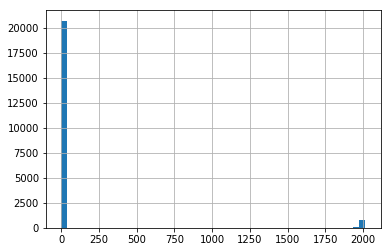

In [54]:
df_house.yr_renovated.hist(bins=50)
plt.show()

In [55]:
# number of missing years
sum(df_house.yr_renovated == 0)

20683

In [58]:
# number of not missing years
sum(df_house.yr_renovated > 0)

914

In [64]:
print(round(sum(df_house.yr_renovated == 0)/len(df_house.yr_renovated)*100,2),'% missing')

95.77 % missing


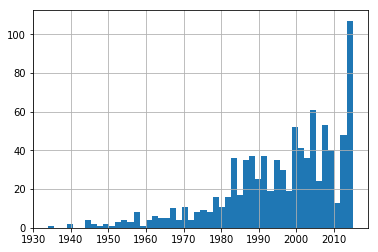

In [60]:
df_house.yr_renovated[df_house.yr_renovated > 0].hist(bins=50)
plt.show()

Almost 96% of the column yr_renovated has missing values (zero) probably because most of the houses have not gone through any major renovation. Thus, the missing values cannot be filled with a mean or median. I do not want to remove the column since this column could give useful information if houses were renovated. I decided to fill the missing values with yr_built. Thus, yr_renovated is like a new column with values mostly from yr_built and partly from years renovated if they were renovated. 

In [73]:
df_house[['yr_built','yr_renovated']][:5]

,yr_built,yr_renovated
0,1955,0
1,1951,1991
2,1933,0
3,1965,0
4,1987,0


In [69]:
np.maximum(df_house.yr_built, df_house.yr_renovated)[:5]

0    1955
1    1991
2    1933
3    1965
4    1987
Name: yr_built, dtype: int64

In [74]:
df_house.yr_renovated = np.maximum(df_house.yr_built, df_house.yr_renovated)

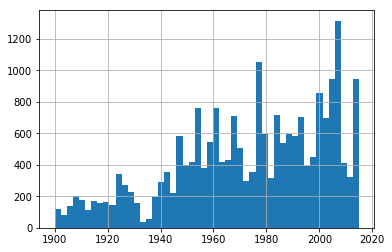

In [77]:
df_house.yr_renovated.hist(bins=50)
plt.show()

I filled the missing values of yr_renovate with yr_built! A new column with booleans showing whether a house was renovated or not might be useful, but I will not make the column yet. 

### zipcode

I will make the zipcode column string types.

In [78]:
df_house.zipcode = df_house.zipcode.astype(str)

In [79]:
type(df_house.zipcode[0])

str

Now all columns in df_house were cleaned. Now it is time to make additional columns using the zipcode column and Niche.com.

<a id= 'Section2'></a>

## 2. Zip code Data from Niche.com

### Web scraping

In [80]:
# find the number of unique zipcode in the original dataset
df_house.zipcode.nunique()

70

In [81]:
url = 'https://www.niche.com/places-to-live/z/98001'
r = requests.get(url)
html = r.text
soup = BeautifulSoup(html)

In [82]:
pretty_soup = soup.prettify()
#print(pretty_soup)

In [83]:
#print(soup.get_text())

All I want are the grades in this kind of list 

                <li class="ordered__list__bucket__item">
                 <div class="profile-grade--two">
                  <div class="profile-grade__label">
                   Public Schools
                  </div>
                  <div class="niche__grade niche__grade--section--b-minus">
                   B-
                  </div>
                 </div>
                </li>
                
The grade 'B-' is in the next sibling of category 'Public Schools'

Here is the useful website I found for this task https://beautiful-soup-4.readthedocs.io/en/latest/#searching-the-tree. I checked how I can get a grade for each category below. 

In [84]:
first_link = soup.find('div', string ='Public Schools')
first_link

<div class="profile-grade__label">Public Schools</div>

In [85]:
first_link.find_next_siblings('div')

[<div class="niche__grade niche__grade--section--b-minus">B-</div>]

In [86]:
first_link.find_next_siblings('div')[0].string

'B-'

In [87]:
first_link = soup.find('div', string ='Crime & Safety')
first_link

<div class="profile-grade__label">Crime &amp; Safety</div>

In [88]:
first_link.find_next_siblings('div')[0].string

'C+'

This worked out well. Now I try how to get the column name automatically.

In [89]:
'_'.join([item.lower() for item in 'Crime & Safety'.split(' ') if item !='&'])

'crime_safety'

In [90]:
# Make a function using what I tried above
def get_Niche_grade(zipcode, category_list):
    '''
    Find grades for the given categories and zip code and
    return a dictionary 
    zipcode: string
    category: list of strings 
    '''
    dic = {'zipcode': zipcode}
    url = "https://www.niche.com/places-to-live/z/" + zipcode
    r = requests.get(url) # get response
    html = r.text     # Extract response as html
    soup = BeautifulSoup(html) # create a BeautifulSoup object
    for category in category_list:
        first_link = soup.find('div', string=category)
        grade = first_link.find_next_siblings('div')[0].string
        key = '_'.join([item.lower() for item in category.split(' ') if item !='&'])
        dic[key] = grade    
    return dic

In [91]:
# All possible zipcodes
zipcodes = df_house.zipcode.unique()

# All available categories in Niche.com 
category_list = ['Public Schools', 'Crime & Safety', 'Housing', 'Nightlife', 
                 'Good for Families', 'Diversity', 'Jobs', 'Weather', 
                 'Cost of Living', 'Health & Fitness', 'Outdoor Activities', 
                 'Commute']

data_list=[] # data will be collected here
for zipcode in zipcodes:
    data_list.append(get_Niche_grade(zipcode, category_list))

In [92]:
# Make a dataframe
df_zipcode = pd.DataFrame(data_list)

In [93]:
df_zipcode.head()

,commute,cost_of_living,crime_safety,diversity,good_for_families,health_fitness,housing,jobs,nightlife,outdoor_activities,public_schools,weather,zipcode
0,B+,C,C+,A+,B,A,C,B-,A-,A,B,B,98178
1,A,C-,C+,A,A-,A+,C,B-,A,A,A-,B,98125
2,A-,C,C+,A-,A,A+,B,B+,A-,A,A+,B,98028
3,A,C,C+,B+,A,A,B-,B+,B,A,A-,B,98136
4,A-,C,C+,B,A+,A+,B+,A-,B-,A,A+,B-,98074


The generated dataframe by web scraping looks great. Now I will wrangle this new dataset before merging it into the main dataset.

### Data wrangling for df_zipcode

In [94]:
# make zipcode as an index
df_zipcode = df_zipcode.set_index('zipcode')

In [95]:
df_zipcode.head()

,commute,cost_of_living,crime_safety,diversity,good_for_families,health_fitness,housing,jobs,nightlife,outdoor_activities,public_schools,weather
zipcode,,,,,,,,,,,,
98178,B+,C,C+,A+,B,A,C,B-,A-,A,B,B
98125,A,C-,C+,A,A-,A+,C,B-,A,A,A-,B
98028,A-,C,C+,A-,A,A+,B,B+,A-,A,A+,B
98136,A,C,C+,B+,A,A,B-,B+,B,A,A-,B
98074,A-,C,C+,B,A+,A+,B+,A-,B-,A,A+,B-


In [96]:
df_zipcode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 98178 to 98039
Data columns (total 12 columns):
commute               70 non-null object
cost_of_living        70 non-null object
crime_safety          70 non-null object
diversity             70 non-null object
good_for_families     70 non-null object
health_fitness        70 non-null object
housing               70 non-null object
jobs                  70 non-null object
nightlife             70 non-null object
outdoor_activities    70 non-null object
public_schools        70 non-null object
weather               70 non-null object
dtypes: object(12)
memory usage: 7.1+ KB


This new dataframe looks great! There seem to be no missing values (only for now).

In [97]:
# Possible grades for each category
for col in df_zipcode.columns:
    print(col)
    print(df_zipcode[col].unique())

commute
['B+' 'A' 'A-' 'B']
cost_of_living
['C' 'C-' 'C+']
crime_safety
['C+']
diversity
['A+' 'A' 'A-' 'B+' 'B' 'B-' 'NG']
good_for_families
['B' 'A-' 'A' 'A+' 'B+' 'B-']
health_fitness
['A' 'A+' 'A-' 'B+']
housing
['C' 'B' 'B-' 'B+' 'C-' 'C+' 'D+']
jobs
['B-' 'B+' 'A-' 'C+' 'B' 'C']
nightlife
['A-' 'A' 'B' 'B-' 'B+' 'A+' 'C-' 'C+']
outdoor_activities
['A' 'A+' 'B' 'A-']
public_schools
['B' 'A-' 'A+' 'B-' 'A' 'B+' 'C+']
weather
['B' 'B-' 'C+' 'C' 'C-']


All categories have at least 3 different grades except for crime_safety whose grade is all C+. Thus, I will drop only the crime_safety column.

In [98]:
# drop the column with a single value
df_zipcode = df_zipcode.drop(columns='crime_safety')

In [99]:
df_zipcode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 98178 to 98039
Data columns (total 11 columns):
commute               70 non-null object
cost_of_living        70 non-null object
diversity             70 non-null object
good_for_families     70 non-null object
health_fitness        70 non-null object
housing               70 non-null object
jobs                  70 non-null object
nightlife             70 non-null object
outdoor_activities    70 non-null object
public_schools        70 non-null object
weather               70 non-null object
dtypes: object(11)
memory usage: 6.6+ KB


Niche.com says they do not grade places with insufficient data. NG means the area was ungraded. I found the diversity column has 'NG'.

In [100]:
df_zipcode[df_zipcode['diversity']=='NG']

,commute,cost_of_living,diversity,good_for_families,health_fitness,housing,jobs,nightlife,outdoor_activities,public_schools,weather
zipcode,,,,,,,,,,,
98002,A,C+,NG,B,A+,C,C+,A-,A+,B-,B
98092,A-,C,NG,B,A,C+,B,A-,A,B,C+
98106,A,C,NG,B+,A,C,C,A,A,A-,B
98055,B,C,NG,B,A,C,B-,B+,A,B-,B


There are 4 of them.

I will transform alphabet grades to make score grades because the score grades might be more helpful for later analysis, but I will keep the original alphabet grades. The below is one way of transforming used for GPA. There is no F, so the lowest grade will be D-. NG will be mapped to None so that it can be easily filled. 

A+ = 4.3
A = 4
A- = 3.7
B+ = 3.3
B = 3
B- = 2.7
C+ = 2.3
C = 2
C- = 1.7
D+ = 1.3
D = 1
D- = 0.7
(F = 0)

In [101]:
grades = ['A+','A','A-','B+','B','B-','C+','C','C-','D+','D','D-','NG']
scores = [4.3, 4.0, 3.7, 3.3, 3, 2.7, 2.3, 2, 1.7, 1.3, 1, 0.7, None]
grade_2_score =dict(list(zip(grades,scores)))
grade_2_score

{'A': 4.0,
 'A+': 4.3,
 'A-': 3.7,
 'B': 3,
 'B+': 3.3,
 'B-': 2.7,
 'C': 2,
 'C+': 2.3,
 'C-': 1.7,
 'D': 1,
 'D+': 1.3,
 'D-': 0.7,
 'NG': None}

In [102]:
df_zipcode_scores = df_zipcode.applymap(lambda x: grade_2_score[x])

In [103]:
df_zipcode_scores.head()

,commute,cost_of_living,diversity,good_for_families,health_fitness,housing,jobs,nightlife,outdoor_activities,public_schools,weather
zipcode,,,,,,,,,,,
98178,3.3,2.0,4.3,3.0,4.0,2.0,2.7,3.7,4.0,3.0,3.0
98125,4.0,1.7,4.0,3.7,4.3,2.0,2.7,4.0,4.0,3.7,3.0
98028,3.7,2.0,3.7,4.0,4.3,3.0,3.3,3.7,4.0,4.3,3.0
98136,4.0,2.0,3.3,4.0,4.0,2.7,3.3,3.0,4.0,3.7,3.0
98074,3.7,2.0,3.0,4.3,4.3,3.3,3.7,2.7,4.0,4.3,2.7


In [104]:
df_zipcode_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 98178 to 98039
Data columns (total 11 columns):
commute               70 non-null float64
cost_of_living        70 non-null float64
diversity             66 non-null float64
good_for_families     70 non-null float64
health_fitness        70 non-null float64
housing               70 non-null float64
jobs                  70 non-null float64
nightlife             70 non-null float64
outdoor_activities    70 non-null float64
public_schools        70 non-null float64
weather               70 non-null float64
dtypes: float64(11)
memory usage: 6.6+ KB


This shows there are 4 missing values in diversty (mapped from 4 NG grades).

In [105]:
df_zipcode_scores.describe()

,commute,cost_of_living,diversity,good_for_families,health_fitness,housing,jobs,nightlife,outdoor_activities,public_schools,weather
count,70.000000,70.000000,66.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,3.805714,1.871429,3.631818,3.712857,4.165714,2.262857,2.978571,3.644286,4.032857,3.642857,2.814286
std,0.282271,0.173742,0.545516,0.507601,0.207738,0.439094,0.447179,0.541773,0.174224,0.606862,0.378129
min,3.000000,1.700000,2.700000,2.700000,3.300000,1.300000,2.000000,1.700000,3.000000,2.300000,1.700000
25%,3.700000,1.700000,3.300000,3.300000,4.000000,2.000000,2.700000,3.300000,4.000000,3.000000,3.000000
50%,4.000000,2.000000,3.700000,4.000000,4.300000,2.300000,3.000000,3.700000,4.000000,3.700000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,4.300000,2.700000,3.300000,4.000000,4.000000,4.000000,3.000000
max,4.000000,2.300000,4.300000,4.300000,4.300000,3.300000,3.700000,4.300000,4.300000,4.300000,3.000000


I will fill NAs in diversity with median.

In [106]:
median = df_zipcode_scores.diversity.median()
median

3.7

In [107]:
df_zipcode_scores.diversity = df_zipcode_scores.diversity.fillna(median)

In [108]:
df_zipcode_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 98178 to 98039
Data columns (total 11 columns):
commute               70 non-null float64
cost_of_living        70 non-null float64
diversity             70 non-null float64
good_for_families     70 non-null float64
health_fitness        70 non-null float64
housing               70 non-null float64
jobs                  70 non-null float64
nightlife             70 non-null float64
outdoor_activities    70 non-null float64
public_schools        70 non-null float64
weather               70 non-null float64
dtypes: float64(11)
memory usage: 6.6+ KB


I will merge this dataframe into the previous df_zipcode, which now will have both alphabet and score grades.

In [109]:
df_zipcode = pd.merge(df_zipcode, df_zipcode_scores, left_index = True, right_index=True, suffixes=['_grade','_score'])

In [110]:
df_zipcode.head()

,commute_grade,cost_of_living_grade,diversity_grade,good_for_families_grade,health_fitness_grade,housing_grade,jobs_grade,nightlife_grade,outdoor_activities_grade,public_schools_grade,...,cost_of_living_score,diversity_score,good_for_families_score,health_fitness_score,housing_score,jobs_score,nightlife_score,outdoor_activities_score,public_schools_score,weather_score
zipcode,,,,,,,,,,,,,,,,,,,,,
98178,B+,C,A+,B,A,C,B-,A-,A,B,...,2.0,4.3,3.0,4.0,2.0,2.7,3.7,4.0,3.0,3.0
98125,A,C-,A,A-,A+,C,B-,A,A,A-,...,1.7,4.0,3.7,4.3,2.0,2.7,4.0,4.0,3.7,3.0
98028,A-,C,A-,A,A+,B,B+,A-,A,A+,...,2.0,3.7,4.0,4.3,3.0,3.3,3.7,4.0,4.3,3.0
98136,A,C,B+,A,A,B-,B+,B,A,A-,...,2.0,3.3,4.0,4.0,2.7,3.3,3.0,4.0,3.7,3.0
98074,A-,C,B,A+,A+,B+,A-,B-,A,A+,...,2.0,3.0,4.3,4.3,3.3,3.7,2.7,4.0,4.3,2.7


I filled the missing score grades in diversity with the median already, but not the original 'NG' grades. The median score for diversity was 3.7 which is A-, so I will replace NG in diversity_grade with A- here.

In [111]:
df_zipcode[df_zipcode['diversity_grade']=='NG']

,commute_grade,cost_of_living_grade,diversity_grade,good_for_families_grade,health_fitness_grade,housing_grade,jobs_grade,nightlife_grade,outdoor_activities_grade,public_schools_grade,...,cost_of_living_score,diversity_score,good_for_families_score,health_fitness_score,housing_score,jobs_score,nightlife_score,outdoor_activities_score,public_schools_score,weather_score
zipcode,,,,,,,,,,,,,,,,,,,,,
98002,A,C+,NG,B,A+,C,C+,A-,A+,B-,...,2.3,3.7,3.0,4.3,2.0,2.3,3.7,4.3,2.7,3.0
98092,A-,C,NG,B,A,C+,B,A-,A,B,...,2.0,3.7,3.0,4.0,2.3,3.0,3.7,4.0,3.0,2.3
98106,A,C,NG,B+,A,C,C,A,A,A-,...,2.0,3.7,3.3,4.0,2.0,2.0,4.0,4.0,3.7,3.0
98055,B,C,NG,B,A,C,B-,B+,A,B-,...,2.0,3.7,3.0,4.0,2.0,2.7,3.3,4.0,2.7,3.0


In [112]:
df_zipcode.diversity_grade = df_zipcode.diversity_grade.replace({'NG':'A-'})

In [113]:
df_zipcode.loc[['98002','98092','98106','98055']]

,commute_grade,cost_of_living_grade,diversity_grade,good_for_families_grade,health_fitness_grade,housing_grade,jobs_grade,nightlife_grade,outdoor_activities_grade,public_schools_grade,...,cost_of_living_score,diversity_score,good_for_families_score,health_fitness_score,housing_score,jobs_score,nightlife_score,outdoor_activities_score,public_schools_score,weather_score
zipcode,,,,,,,,,,,,,,,,,,,,,
98002,A,C+,A-,B,A+,C,C+,A-,A+,B-,...,2.3,3.7,3.0,4.3,2.0,2.3,3.7,4.3,2.7,3.0
98092,A-,C,A-,B,A,C+,B,A-,A,B,...,2.0,3.7,3.0,4.0,2.3,3.0,3.7,4.0,3.0,2.3
98106,A,C,A-,B+,A,C,C,A,A,A-,...,2.0,3.7,3.3,4.0,2.0,2.0,4.0,4.0,3.7,3.0
98055,B,C,A-,B,A,C,B-,B+,A,B-,...,2.0,3.7,3.0,4.0,2.0,2.7,3.3,4.0,2.7,3.0


'NG' grades in diversity_grade were successfully changed to A-.

<a id= 'Section3'></a>

## 3. Merge zip code data into house data

In [114]:
# Left join
df = pd.merge(df_house, df_zipcode, how ='left', left_on = 'zipcode', right_index=True)

In [115]:
df.head()

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,cost_of_living_score,diversity_score,good_for_families_score,health_fitness_score,housing_score,jobs_score,nightlife_score,outdoor_activities_score,public_schools_score,weather_score
0,0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,...,2.0,4.3,3.0,4.0,2.0,2.7,3.7,4.0,3.0,3.0
1,1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,...,1.7,4.0,3.7,4.3,2.0,2.7,4.0,4.0,3.7,3.0
2,2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,...,2.0,3.7,4.0,4.3,3.0,3.3,3.7,4.0,4.3,3.0
3,3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,...,2.0,3.3,4.0,4.0,2.7,3.3,3.0,4.0,3.7,3.0
4,4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,...,2.0,3.0,4.3,4.3,3.3,3.7,2.7,4.0,4.3,2.7


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 45 columns):
index                       21597 non-null int64
id                          21597 non-null object
date                        21597 non-null datetime64[ns]
price                       21597 non-null float64
bedrooms                    21597 non-null int64
bathrooms                   21597 non-null float64
sqft_living                 21597 non-null int64
sqft_lot                    21597 non-null int64
floors                      21597 non-null float64
waterfront                  21597 non-null int64
view                        21597 non-null int64
condition                   21597 non-null int64
grade                       21597 non-null int64
sqft_above                  21597 non-null int64
sqft_basement               21597 non-null int64
yr_built                    21597 non-null int64
yr_renovated                21597 non-null int64
zipcode                     21597 non-null

In [117]:
df[df.zipcode == '98001'].head()

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,cost_of_living_score,diversity_score,good_for_families_score,health_fitness_score,housing_score,jobs_score,nightlife_score,outdoor_activities_score,public_schools_score,weather_score
38,38,7895500070,2015-02-13,240000.0,4,1.0,1220,8075,1.0,0,...,2.0,4.0,3.0,4.0,2.0,2.7,3.7,4.0,2.7,3.0
67,67,3717000160,2014-10-09,287000.0,4,2.5,2240,4648,2.0,0,...,2.0,4.0,3.0,4.0,2.0,2.7,3.7,4.0,2.7,3.0
114,114,8961960160,2014-10-28,480000.0,4,2.5,3230,16171,2.0,0,...,2.0,4.0,3.0,4.0,2.0,2.7,3.7,4.0,2.7,3.0
213,213,4014400292,2015-01-14,465000.0,3,2.5,2714,17936,2.0,0,...,2.0,4.0,3.0,4.0,2.0,2.7,3.7,4.0,2.7,3.0
292,292,1115450240,2014-10-22,360000.0,4,2.5,2160,9528,2.0,0,...,2.0,4.0,3.0,4.0,2.0,2.7,3.7,4.0,2.7,3.0


In [118]:
df.columns

Index(['index', 'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sales_order',
       'commute_grade', 'cost_of_living_grade', 'diversity_grade',
       'good_for_families_grade', 'health_fitness_grade', 'housing_grade',
       'jobs_grade', 'nightlife_grade', 'outdoor_activities_grade',
       'public_schools_grade', 'weather_grade', 'commute_score',
       'cost_of_living_score', 'diversity_score', 'good_for_families_score',
       'health_fitness_score', 'housing_score', 'jobs_score',
       'nightlife_score', 'outdoor_activities_score', 'public_schools_score',
       'weather_score'],
      dtype='object')

I will drop the column 'index', which was automatically made when merging.

In [119]:
df = df.drop(columns='index')

In [120]:
df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,cost_of_living_score,diversity_score,good_for_families_score,health_fitness_score,housing_score,jobs_score,nightlife_score,outdoor_activities_score,public_schools_score,weather_score
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,2.0,4.3,3.0,4.0,2.0,2.7,3.7,4.0,3.0,3.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,1.7,4.0,3.7,4.3,2.0,2.7,4.0,4.0,3.7,3.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,2.0,3.7,4.0,4.3,3.0,3.3,3.7,4.0,4.3,3.0


Looks great! Now the data has 44 columns with both house features and zip code features. All dataframes cleaned or generated here wil be saved as csv files.

- df_house
- df_zipcode
- df

In [121]:
# Save DataFrames to csv files
df_house.to_csv('df_house.csv')
df_zipcode.to_csv('df_zipcode.csv')
df.to_csv('df_house_zipcode.csv')